In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
# list(PATH.iterdir())

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Data augmentation

In [6]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Train-validation split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [9]:
path=PATH/"train-315"

In [10]:
files = get_files(path)

In [11]:
# files

In [12]:
file_labels = [p.parts[-2] for p in files]

In [13]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [14]:
# from collections import Counter

In [15]:
# Counter(y_train), Counter(y_valid)

# Dataset

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [18]:
labels = [p.parts[-1] for p in paths]

In [19]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [20]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [21]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [22]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [23]:
# len(train_ds), len(valid_ds)

In [24]:
x, y = train_ds[0]

In [25]:
x.shape, y

((3, 299, 299), 5)

In [26]:
batch_size = 50

In [27]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [29]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda().float()
y = y.cuda()

In [31]:
# x.shape, y.shape

In [32]:
# y.shape[0]

# Initialize pre-trained model with frozen hidden layers

In [33]:
resnet = models.resnet34(pretrained=True)

In [34]:
layers = list(resnet.children())

In [35]:
# print(len(layers))

In [36]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [37]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 6)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.fc(x)
        return x

In [38]:
model = Resnet().cuda()

In [39]:
# x_features = model.top_model(x)

In [40]:
# x_features.shape

In [41]:
# x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)

In [42]:
# x_features_ave.shape

In [43]:
# x_features_ave.size(0), x_features_ave.shape[0]

In [44]:
# x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)

In [45]:
# x_features_flatten.shape

In [46]:
out = model(x)

In [47]:
# out

In [48]:
_, pred = torch.max(out, 1)

In [49]:
# pred

In [50]:
# y

In [51]:
# pred.eq(y).sum()

In [52]:
F.cross_entropy(out, y).item()

1.9382858276367188

# Compute accuracy

In [53]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [54]:
val_metrics(model, valid_dl)

(1.985863486925761, 0.16444444444444445)

# Train model with fixed learning rate

In [55]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [56]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        prev_val_acc = 0.0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.8:
                path = "{0}/ft_resnet_loss_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [57]:
model = Resnet().cuda()

In [58]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.498 val loss 0.806 val accuracy 0.717
train loss 0.772 val loss 0.853 val accuracy 0.681
train loss 0.811 val loss 0.838 val accuracy 0.724
train loss 0.787 val loss 1.001 val accuracy 0.701
train loss 0.737 val loss 0.849 val accuracy 0.710


In [59]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [60]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [61]:
save_model(model, model_path/"initial_resnet.pth")

# Unfreeze top layers, train with lower learning rate

In [62]:
model = Resnet().cuda()

In [63]:
load_model(model, model_path/"initial_resnet.pth")

In [64]:
val_metrics(model, valid_dl)

(0.798882888423072, 0.7488888888888889)

In [65]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [66]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [67]:
unfreeze(model, 7)
unfreeze(model, 6)

In [68]:
train(model, epochs=20, learning_rate=0.001)

train loss 1.293 val loss 0.893 val accuracy 0.679
train loss 0.478 val loss 0.737 val accuracy 0.758
train loss 0.363 val loss 0.794 val accuracy 0.761
train loss 0.264 val loss 0.572 val accuracy 0.812
/home/ubuntu/models/sandwich/ft_resnet_loss_81.pth
train loss 0.176 val loss 1.091 val accuracy 0.771
train loss 0.178 val loss 0.695 val accuracy 0.810
/home/ubuntu/models/sandwich/ft_resnet_loss_81.pth
train loss 0.128 val loss 0.887 val accuracy 0.769
train loss 0.095 val loss 0.855 val accuracy 0.786
train loss 0.117 val loss 1.215 val accuracy 0.750
/home/ubuntu/models/sandwich/ft_resnet_loss_80.pth
train loss 0.088 val loss 0.776 val accuracy 0.812
/home/ubuntu/models/sandwich/ft_resnet_loss_81.pth
/home/ubuntu/models/sandwich/ft_resnet_loss_80.pth


In [69]:
save_model(model, model_path/"initial_unfreeze_resnet.pth")

In [70]:
model = Resnet().cuda()

In [71]:
load_model(model, model_path/"initial_unfreeze_resnet.pth")

In [72]:
val_metrics(model, valid_dl)

(0.8814398679468367, 0.8022222222222222)

# Learning rate range test

In [73]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [74]:
model = Resnet().cuda()

In [75]:
lrs, losses = LR_range_finder(model, train_dl)

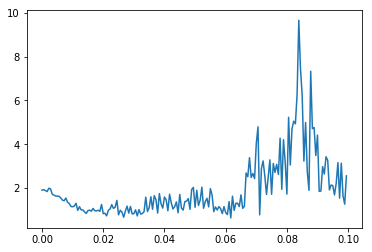

In [76]:
plt.plot(lrs, losses)
plt.show()

# Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

## Initialize model with groups of layers

In [73]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [74]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

## 1-cycle rate training, unfreeze all hidden layers

In [75]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [59]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.06, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            if idx == int(0.2*iterations):
                model.unfreeze(0)
                print(idx, "unfreezing 0")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.8:
                path = "{0}/ft_resnet_loss_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [60]:
batch_size = 50

In [61]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [62]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [63]:
model = ResnetV2().cuda()

In [64]:
val_metrics(model, valid_dl)

(1.9074531859821744, 0.13111111111111112)

In [65]:
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.06, epochs=30)

train_loss 1.354 val_loss 0.993 val_acc 0.654
train_loss 0.926 val_loss 0.831 val_acc 0.674
216 unfreezing 1
train_loss 0.922 val_loss 1.230 val_acc 0.598
train_loss 2.038 val_loss 3.345 val_acc 0.266
train_loss 1.407 val_loss 2.358 val_acc 0.404
432 unfreezing 0
train_loss 1.140 val_loss 1.846 val_acc 0.420
train_loss 2.021 val_loss 1.848 val_acc 0.161
train_loss 1.810 val_loss 1.822 val_acc 0.180
train_loss 1.795 val_loss 1.786 val_acc 0.178
train_loss 1.783 val_loss 2.048 val_acc 0.181
train_loss 1.748 val_loss 1.858 val_acc 0.260
train_loss 1.726 val_loss 1.760 val_acc 0.230
train_loss 1.711 val_loss 1.750 val_acc 0.253
train_loss 1.708 val_loss 1.728 val_acc 0.276
train_loss 1.682 val_loss 1.765 val_acc 0.260
train_loss 1.665 val_loss 1.725 val_acc 0.252
train_loss 1.655 val_loss 1.933 val_acc 0.296
train_loss 1.624 val_loss 1.728 val_acc 0.287
train_loss 1.584 val_loss 1.627 val_acc 0.356
train_loss 1.538 val_loss 1.783 val_acc 0.294
train_loss 1.505 val_loss 1.615 val_acc 0.324


1.0330154771606128

## 1-cycle rate training, unfreeze top hidden layers

In [76]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.06, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
#             if idx == int(0.2*iterations):
#                 model.unfreeze(0)
#                 print(idx, "unfreezing 0")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.8:
                path = "{0}/ft_resnet_loss_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [77]:
model = ResnetV2().cuda()

In [78]:
val_metrics(model, valid_dl)

(1.9448052909639146, 0.14555555555555555)

In [80]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.06, epochs=30)

train_loss 1.337 val_loss 1.000 val_acc 0.636
train_loss 0.929 val_loss 0.852 val_acc 0.698
216 unfreezing 1
train_loss 1.041 val_loss 1.015 val_acc 0.686
train_loss 2.133 val_loss 1.690 val_acc 0.362
train_loss 1.505 val_loss 232.954 val_acc 0.150
train_loss 1.311 val_loss 1.286 val_acc 0.534
train_loss 1.018 val_loss 1.309 val_acc 0.554
train_loss 0.890 val_loss 1.083 val_acc 0.643
train_loss 0.809 val_loss 1.038 val_acc 0.616
train_loss 0.736 val_loss 0.851 val_acc 0.729
train_loss 0.681 val_loss 1.183 val_acc 0.636
train_loss 0.601 val_loss 0.826 val_acc 0.743
train_loss 0.551 val_loss 0.860 val_acc 0.729
train_loss 0.507 val_loss 0.995 val_acc 0.693
train_loss 0.488 val_loss 1.024 val_acc 0.681
train_loss 0.416 val_loss 0.894 val_acc 0.749
train_loss 0.426 val_loss 0.809 val_acc 0.727
train_loss 0.359 val_loss 0.787 val_acc 0.763
train_loss 0.329 val_loss 0.729 val_acc 0.780
train_loss 0.283 val_loss 0.928 val_acc 0.767
train_loss 0.247 val_loss 0.838 val_acc 0.791
train_loss 0.22

0.0612638705319518